# Setup

Making the necessary imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

# from preprocessing.py
from preprocessing import ( 
    create_validation_split,
    get_dataset_statistics,
    augment_minority_classes,
    get_augmentation_pipeline_no_tensor,
    load_and_preprocess_image,
    CATEGORIES_MAP
)

# Data Preprocessing for Grain Disease Classification

This notebook documents all preprocessing steps applied to the grain dataset.

## Preprocessing Steps:
1. Validation Split Creation
2. Class Imbalances Check
3. Minority Classes Augmentation
4. Augmentation Pipeline Inspection
5. Preprocessed Dataset Summary

## Validation Split Creation

We'll take 15% off from the training data to use as validation data.
- **Why not more?** We might starve the trianing data and harm the model's learning.
- **Why not less?** Our dataset has large imbalances, smaller splits would exacerbate variance for the minority classes and lead to unreliable estimates.

**Intuition:** "I'll spend enough to shake the hunger off now, not too much that I'll starve myself later from having no money."

In [2]:
print("Creating validation splits...")
maize_stats = create_validation_split("maize", val_ratio=0.15, random_state=42)
rice_stats = create_validation_split("rice", val_ratio=0.15, random_state=42)

Creating validation splits...
Validation split already exists for maize, skipping.
Validation split already exists for rice, skipping.


### Validation Split Visualization

In order to have a better look at the split, let's visualize it via a bar graph.

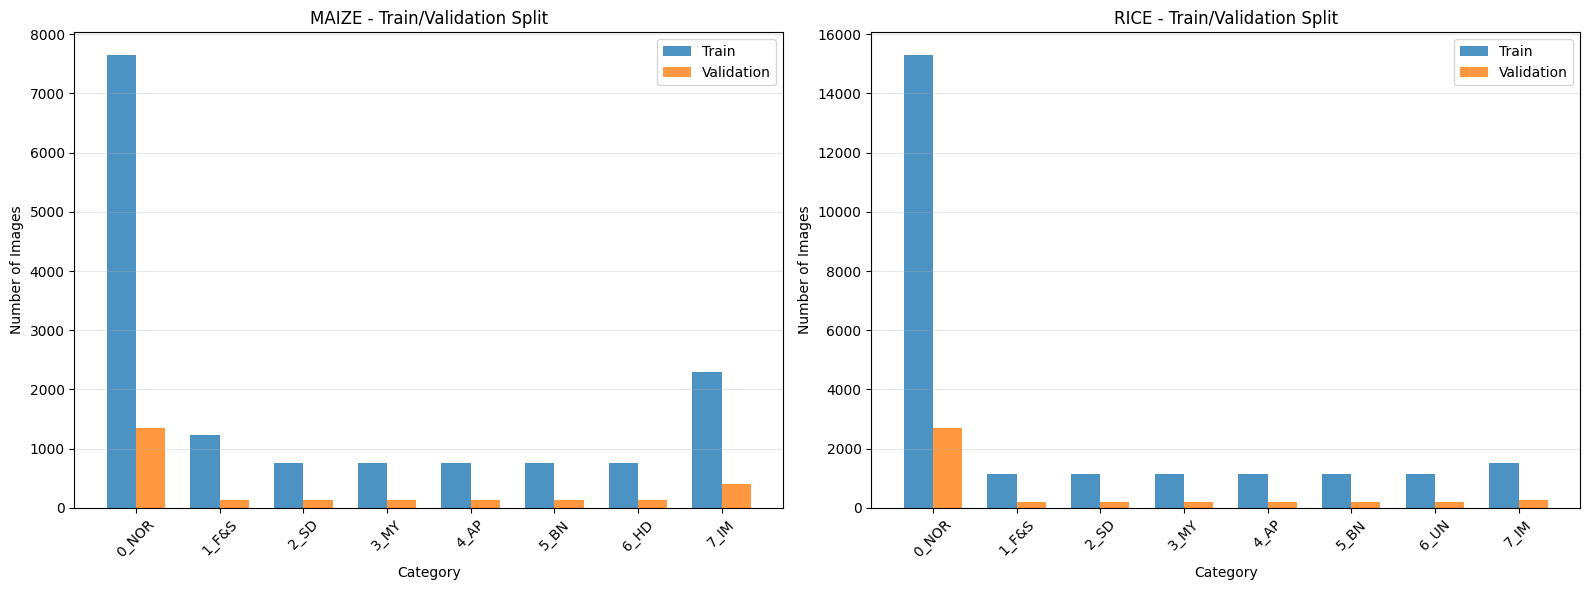

In [3]:
# If create_validation_split skipped (already exists), read counts from disk instead
def get_split_counts(grain, stats_from_function):
    if stats_from_function:
        return stats_from_function
    disk_stats = get_dataset_statistics(grain, splits=['train', 'val'])
    result = {}
    for cat in CATEGORIES_MAP[grain]:
        result[cat] = {
            'train': disk_stats.get('train', {}).get(cat, 0),
            'val': disk_stats.get('val', {}).get(cat, 0)
        }
    return result

maize_counts = get_split_counts("maize", maize_stats)
rice_counts = get_split_counts("rice", rice_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (grain, counts) in enumerate([("maize", maize_counts), ("rice", rice_counts)]):
    if not counts:
        continue
    categories = list(counts.keys())
    train_counts = [counts[cat]['train'] for cat in categories]
    val_counts = [counts[cat]['val'] for cat in categories]
    x = np.arange(len(categories))
    width = 0.35
    axes[idx].bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
    axes[idx].bar(x + width/2, val_counts, width, label='Validation', alpha=0.8)
    axes[idx].set_xlabel('Category')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_title(f'{grain.upper()} - Train/Validation Split')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(categories, rotation=45)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Class Imbalances Check

Before augmenting, we look at the current image counts per category to see imbalances. 

**Intuition:** If some categories have far fewer images, the model will see them less during training and become biased toward the majority classes.

In [4]:
print("Class counts before augmentation:\n")
for grain in ["maize", "rice"]:
    print(f"{grain.upper()}:")
    stats = get_dataset_statistics(grain, splits=['train', 'val', 'test'])
    df = pd.DataFrame(stats).fillna(0).astype(int)
    print(df)
    train_counts = df['train'] if 'train' in df.columns else pd.Series()
    if not train_counts.empty:
        print()
        print(f"Most common class:  {train_counts.idxmax()} ({train_counts.max()} images)")
        print(f"Least common class: {train_counts.idxmin()} ({train_counts.min()} images)")
        print(f"Imbalance ratio: {train_counts.max() / train_counts.min():.1f}x")
    print()

Class counts before augmentation:

MAIZE:
       train   val  test
0_NOR   7650  1350  1000
1_F&S   1238   135   100
2_SD     765   135   100
3_MY     765   135   100
4_AP     765   135   100
5_BN     765   135   100
6_HD     765   135   100
7_IM    2295   405   300

Most common class:  0_NOR (7650 images)
Least common class: 2_SD (765 images)
Imbalance ratio: 10.0x

RICE:
       train   val  test
0_NOR  15300  2700  2000
1_F&S   1136   200   150
2_SD    1148   202   150
3_MY    1148   202   150
4_AP    1148   202   150
5_BN    1140   201   150
6_UN    1135   200   150
7_IM    1530   270   200

Most common class:  0_NOR (15300 images)
Least common class: 6_UN (1135 images)
Imbalance ratio: 13.5x



## Minority Classes Augmentation
To fix the imbalance, we generate synthetic images for the underrepresented classes.

We do this by applying random augmentations (flips, rotations, brightness/contrast shifts, noise) to the existing images and continue doing this until every class in the training set is the same count as the largest class.

**Note:** Augmented images in the training set are saved with an aug_ prefix.

### Augmentations made:
- Random 90° rotations
- Random rotations
- Horizontal/vertical flips
- Brightness/contrast adjustments
- HSV color shifts
- Gaussian noise

**Intuition:** The random augmentations exposes models to unique data making the learning process fair and improving detection for all classes.

In [5]:
augment_minority_classes("maize", random_state=42)
augment_minority_classes("rice", random_state=42)

Augmented files already exist for maize, skipping.
To re-run, manually delete files with the aug_ prefix from train/ first.



c:\Users\ADMIN\Desktop\grain-disease-vision-model\preprocessing.py:227: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 40.0), p=0.3),



Augmenting minority classes for RICE...
Target count per class: 15300
Current counts: {'0_NOR': 15300, '1_F&S': 1136, '2_SD': 1148, '3_MY': 1148, '4_AP': 1148, '5_BN': 1140, '6_UN': 1135, '7_IM': 1530}

  0_NOR: Already has 15300 images, no augmentation needed.
  1_F&S: 1136 images → generating 14164 more...


  1_F&S: Done. Now has 15300 images.
  2_SD: 1148 images → generating 14152 more...


  2_SD: Done. Now has 15300 images.
  3_MY: 1148 images → generating 14152 more...


  3_MY: Done. Now has 15300 images.
  4_AP: 1148 images → generating 14152 more...


  4_AP: Done. Now has 15300 images.
  5_BN: 1140 images → generating 14160 more...


KeyboardInterrupt: 

Now, we verify that the class counts of the training set are balanced.

In [ ]:
print("Class counts after augmentation:\n")
for grain in ["maize", "rice"]:
    print(f"{grain.upper()}:")
    stats = get_dataset_statistics(grain, splits=['train'])
    df = pd.DataFrame(stats).fillna(0).astype(int)
    print(df)
    train_counts = df['train'] if 'train' in df.columns else pd.Series()
    if not train_counts.empty:
        print(f"  All classes now have ~{train_counts.max()} images")
    print()

## Augmentation Pipeline Inspection

In preparation for neural network training, shown below is what the augmentation pipeline actually does to an image.

**Note:** This is purely for inspection and does not save touch the dataset in the disk.

### Augmentations made:
- Random 90° rotations
- Horizontal/vertical flips
- Brightness/contrast adjustments
- HSV color shifts
- Gaussian noise

### Other adjustments
- Image size standardization (224x224px)
- Normalization

In [ ]:
def show_augmentation_examples(grain_type, category, n_examples=3):
    base_path = Path(f'./dataset/images/{grain_type}/train/{category}')
    # Only use original images (no aug_ files) for cleaner visualization
    images = [p for p in base_path.glob("*.png") if not p.name.startswith("aug_")][:n_examples]
    if not images:
        print(f'No images found in {base_path}')
        return
    aug_pipeline = get_augmentation_pipeline_no_tensor(split='train', img_size=224)
    fig, axes = plt.subplots(n_examples, 2, figsize=(8, n_examples * 3))
    for i, img_path in enumerate(images):
        img_orig = cv2.imread(str(img_path))
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        img_aug = aug_pipeline(image=img_orig.copy())['image']
        axes[i, 0].imshow(img_orig)
        axes[i, 0].set_title(f'Original - {img_path.name}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(img_aug)
        axes[i, 1].set_title('Augmented')
        axes[i, 1].axis('off')
    plt.suptitle(f'{grain_type.upper()} - {category} Augmentation Examples')
    plt.tight_layout()
    plt.show()

show_augmentation_examples("maize", "0_NOR", n_examples=3)
show_augmentation_examples("rice", "0_NOR", n_examples=3)

## Final Dataset Summary

Here's a full breakdown of image counts across all splits after preprocessing is complete.

In [ ]:
print("\n=== FINAL DATASET SUMMARY ===")
for grain in ["maize", "rice"]:
    print(f"\n{grain.upper()}:")
    stats = get_dataset_statistics(grain, splits=['train', 'val', 'test'])
    
    df = pd.DataFrame(stats).fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    print(df)
    print(f"\nGrand Total: {df['Total'].sum()} images")
    print(f"Train/Val/Test Ratio: {df.loc[:, 'train'].sum()}:{df.loc[:, 'val'].sum()}:{df.loc[:, 'test'].sum()}")

print("=== FINAL DATASET SUMMARY ===")
for grain in ["maize", "rice"]:
    print(f"\n{grain.upper()}:")
    stats = get_dataset_statistics(grain, splits=['train', 'val', 'test'])
    df = pd.DataFrame(stats).fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    print(df)
    print(f"\nGrand Total: {df['Total'].sum()} images")
    cols = df.columns.tolist()
    parts = [f"{df[c].sum()} {c}" for c in ['train', 'val', 'test'] if c in cols]
    print(f"Split breakdown: {' | '.join(parts)}")